In [1]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score, GridSearchCV,cross_val_predict
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,  r2_score
import numpy as np
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"

In [2]:
mat.rcParams.update({'figure.figsize':(20,15),'font.size':14})

In [3]:
covid19_train = pd.read_csv('../input/covid19-global-forecasting-week-2/train.csv')
covid19_test = pd.read_csv('../input/covid19-global-forecasting-week-2/test.csv')

In [4]:
covid19_train.rename(columns={'Id':'ForecastId'},inplace=True)

In [5]:
covid19_train['Date-All'] = covid19_train['Date'].str.replace('-','').astype(int)
covid19_test['Date-All'] = covid19_test['Date'].str.replace('-','').astype(int)

In [6]:
covid19_train['Date'] = pd.to_datetime(covid19_train['Date'])
covid19_test['Date'] = pd.to_datetime(covid19_test['Date'])

In [7]:
covid19_gdf = covid19_train.groupby(['Date','Country_Region'])['ConfirmedCases'].sum().reset_index()
covid19_gdf['date'] = pd.to_datetime(covid19_gdf['Date'])
covid19_gdf['date'] = covid19_gdf['date'].dt.strftime('%m/%d/%Y')

# No. Confirmed Cases By Country And Time

In [8]:
fig = px.scatter_geo(covid19_gdf.fillna(0), locations="Country_Region", locationmode='country names', 
                     color="ConfirmedCases", size="ConfirmedCases", hover_name="Country_Region", 
                     projection="natural earth", animation_frame="date", 
                     title='Coronavirus Spread', color_continuous_scale="OrRd")
fig.update(layout_coloraxis_showscale=False)
fig.show()

# No. Confirmed Cases By Country

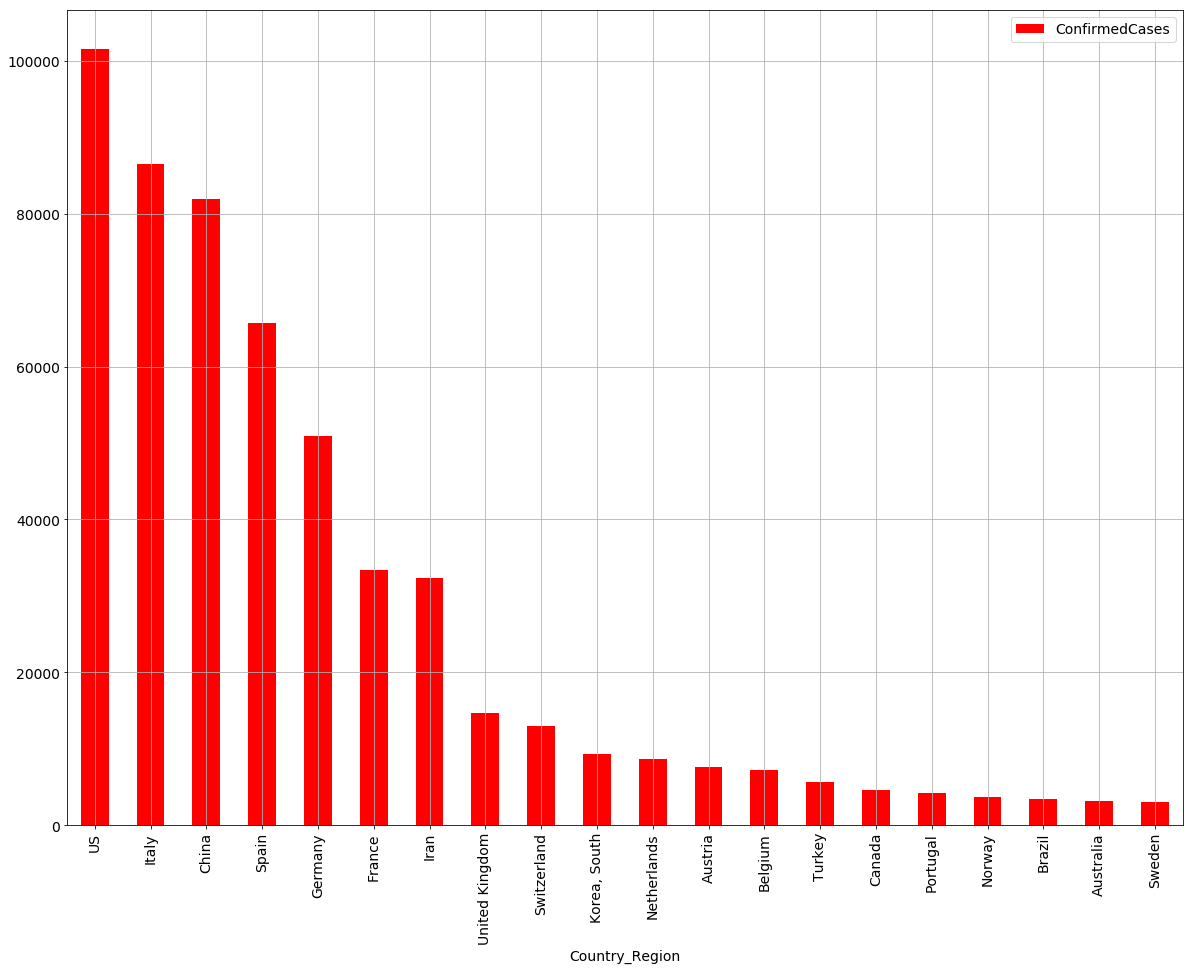

In [9]:
totalCountryCases = covid19_train.drop_duplicates(['Province_State', 'Country_Region'],keep='last').groupby(['Country_Region'])[['ConfirmedCases']].sum().sort_values('ConfirmedCases',ascending=False)
totalCountryCases.head(20).plot(kind='bar',color='r')
plt.grid()
plt.show()

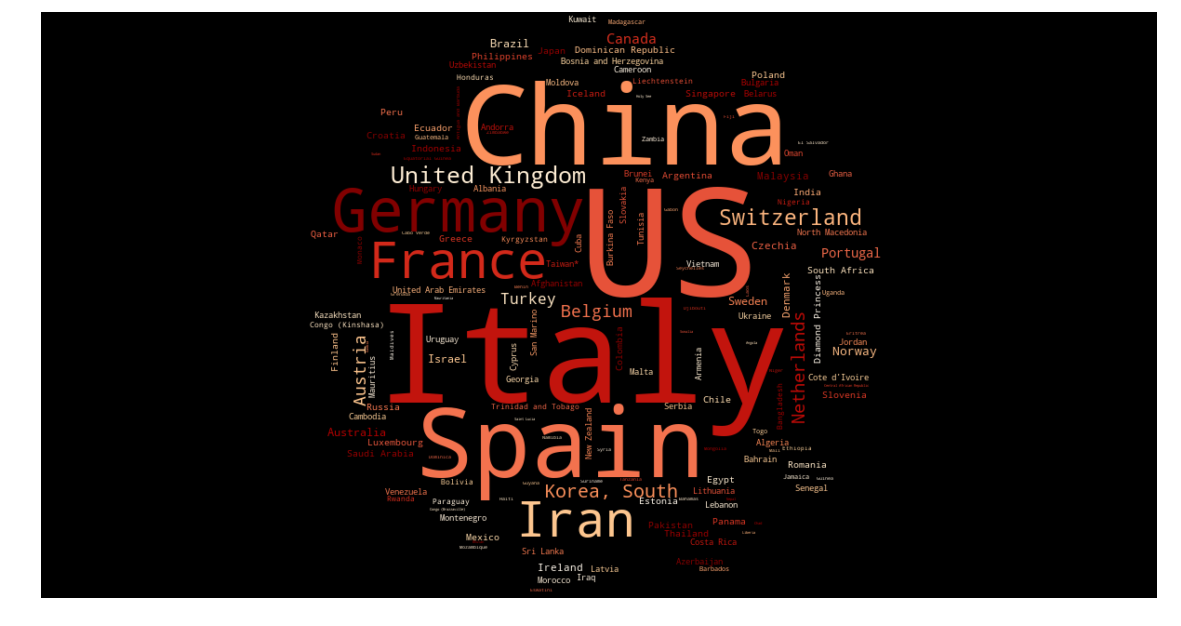

In [10]:
mask=np.array(Image.open("../input/coronavirusimage/coronavirus.png"))
wc = WordCloud(background_color="black",colormap=plt.cm.OrRd,collocations = False,mask=mask).generate_from_frequencies(totalCountryCases.to_dict()['ConfirmedCases'])
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
wc.to_file('Coronavirus-spread.png')
plt.show()


# No. Deaths By Country

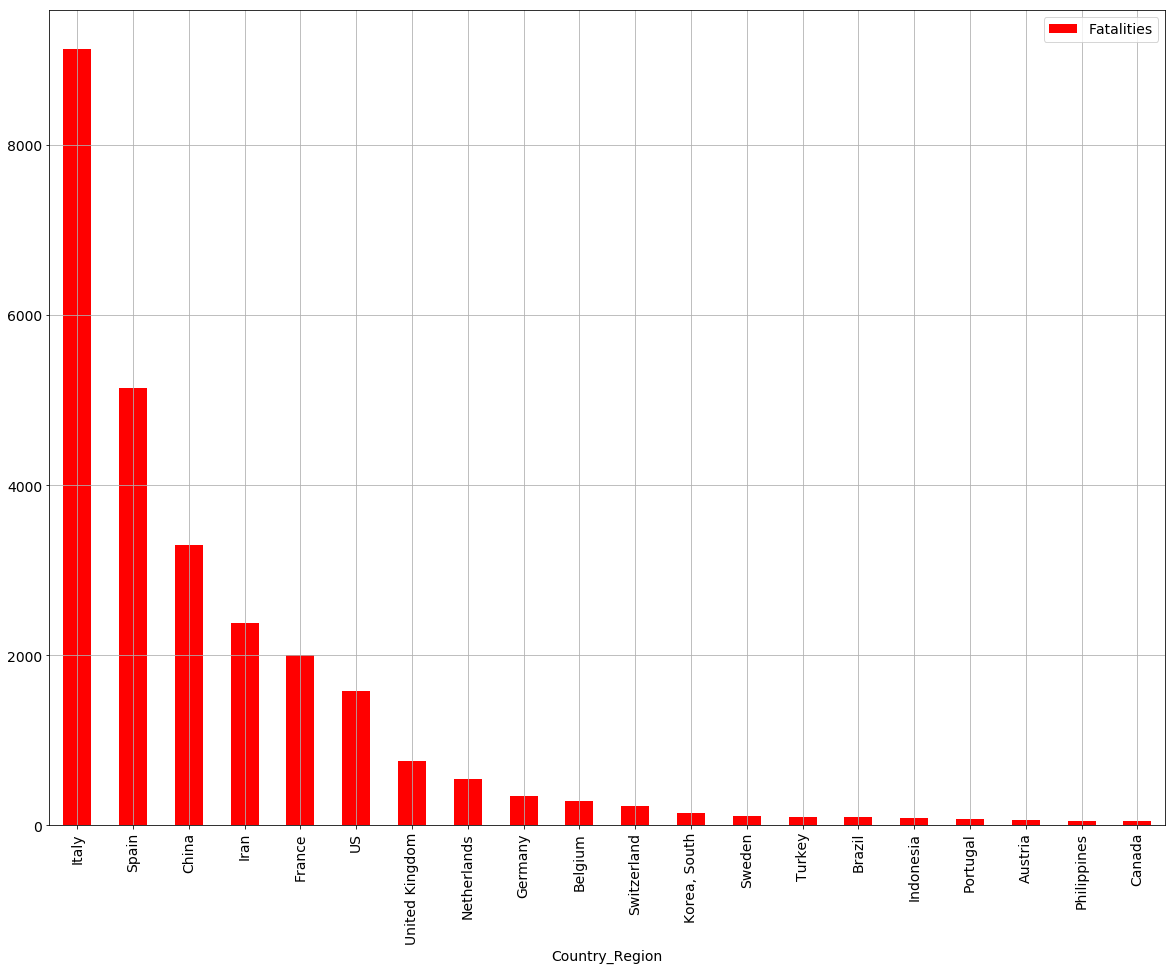

In [11]:
totalCountryFatalities = covid19_train.drop_duplicates(['Province_State', 'Country_Region'],keep='last').groupby(['Country_Region'])[['Fatalities']].sum().sort_values('Fatalities',ascending=False)

totalCountryFatalities.head(20).plot(kind='bar',color='r')
plt.grid()
plt.show()

In [12]:
str(round((totalCountryFatalities['Fatalities'].sum()/totalCountryCases['ConfirmedCases'].sum())*100,1)) + '% Deaths out of total of ' + str(totalCountryCases['ConfirmedCases'].sum()/1e3) + 'K infection'

'4.6% Deaths out of total of 593.012K infection'

In [13]:
totalDailyCases = covid19_train.groupby(['Date'])[['ConfirmedCases']].sum().sort_values('ConfirmedCases',ascending=False)

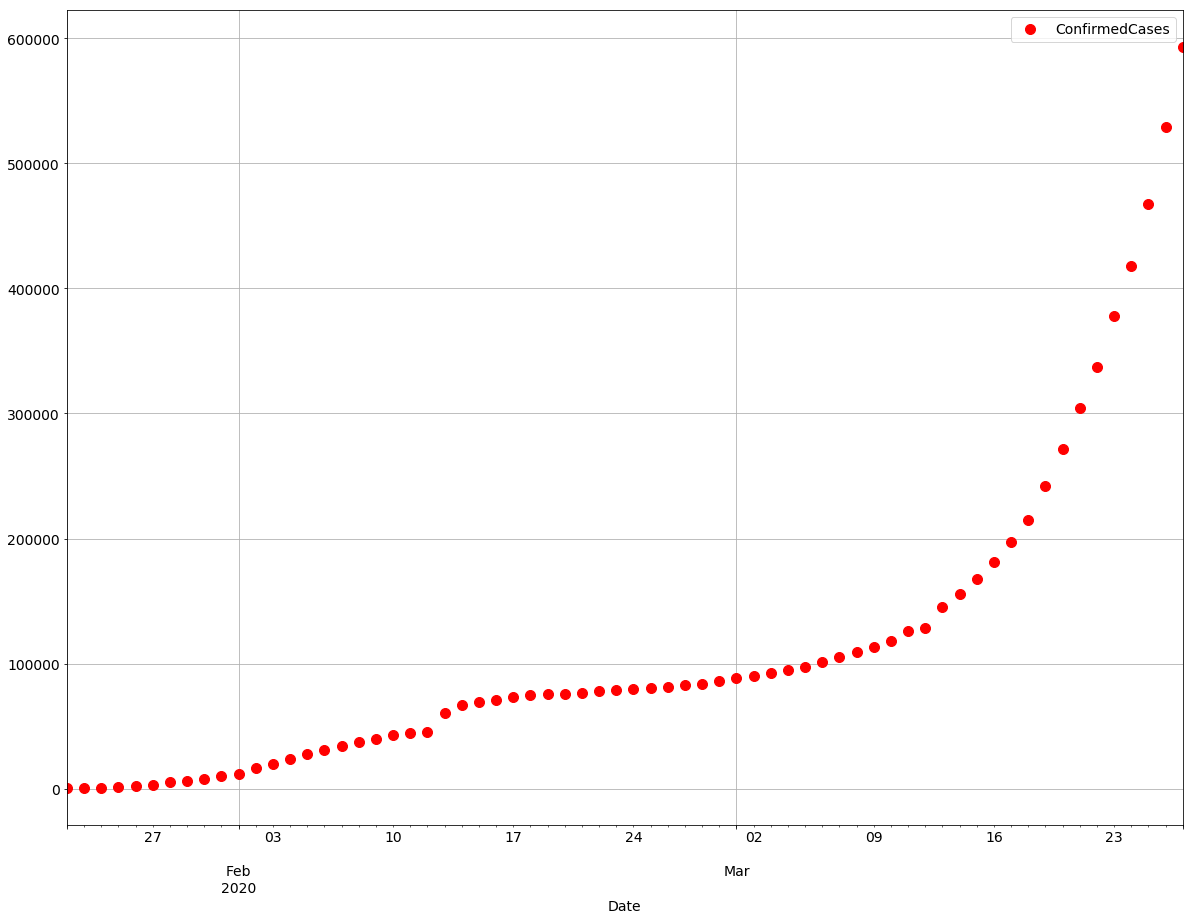

In [14]:
totalDailyCases.plot(grid=True,linestyle='', marker='.',color='r',markersize=20)
plt.show()

In [15]:
totalDailyCases['prop'] = round((totalDailyCases['ConfirmedCases'].cumsum()/totalDailyCases['ConfirmedCases'].sum())*100,2)

In [16]:
'80% of the infections were in last '+ str(len(totalDailyCases.loc[totalDailyCases['prop'] <= 80])) + ' days'

'80% of the infections were in last 29 days'

Givent that, the first dase daignosed in November 17

In [17]:
'A proportion of ' + str(round(len(totalDailyCases.loc[totalDailyCases['prop'] <= 80])/(len(totalDailyCases)+len(pd.date_range('17-11-2019','21-01-2020')))*100)) + '% from last days had the highest spread'

'A proportion of 22% from last days had the highest spread'

# Forecasting

In [18]:
dependant_vars = ['ConfirmedCases', 'Fatalities']
y_train_CC = covid19_train.loc[:,[dependant_vars[0]]].values
y_train_fa = covid19_train.loc[:,[dependant_vars[1]]].values

In [19]:
X = pd.concat([covid19_train.drop(dependant_vars,1), covid19_test],sort=False).set_index('ForecastId')

In [20]:
X = pd.get_dummies(X,drop_first=True)

In [21]:
X_train = X.iloc[:len(covid19_train),:].drop('Date',1).copy()
X_test = X.iloc[len(covid19_train):,:].drop('Date',1).copy()

In [22]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, 
    scoring='neg_mean_squared_error', verbose=0, n_jobs=3)
    
grid_result = gsc.fit(X_train, y_train_CC)
best_params = grid_result.best_params_

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [23]:
best_params

{'max_depth': 3, 'n_estimators': 10}

In [24]:
kf = KFold(n_splits = 10, shuffle=True)

In [25]:
reg = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               
                            random_state=False, verbose=False)

In [26]:
rmse = []

In [27]:
for i in range(10):
    offset = next(kf.split(X_train),None)
    x_train = X_train.iloc[offset[0]]
    x_test = X_train.iloc[offset[1]]
    Y_train = y_train_CC[offset[0]]
    Y_test = y_train_CC[offset[1]]

    reg.fit(x_train, Y_train.reshape(-1))
    ypred = reg.predict(x_test)
    rmse.append(np.sqrt(mean_squared_error(Y_test, ypred)))

In [28]:
X_train

,Date-All,Province_State_Alaska,Province_State_Alberta,Province_State_Anhui,Province_State_Arizona,Province_State_Arkansas,Province_State_Aruba,Province_State_Australian Capital Territory,Province_State_Beijing,Province_State_Bermuda,...,Country_Region_Uganda,Country_Region_Ukraine,Country_Region_United Arab Emirates,Country_Region_United Kingdom,Country_Region_Uruguay,Country_Region_Uzbekistan,Country_Region_Venezuela,Country_Region_Vietnam,Country_Region_Zambia,Country_Region_Zimbabwe
ForecastId,,,,,,,,,,,,,,,,,,,,,
1,20200122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20200123,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20200124,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20200125,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,20200126,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29362,20200323,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
29363,20200324,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
29364,20200325,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
rmse

[2061.2211518424224,
 1011.2444147600188,
 2355.073410420505,
 2064.1759266409167,
 1948.9926635294478,
 1841.8947590271675,
 2048.958704061796,
 1930.0741056665988,
 2103.6932917286367,
 1440.3067443547502]

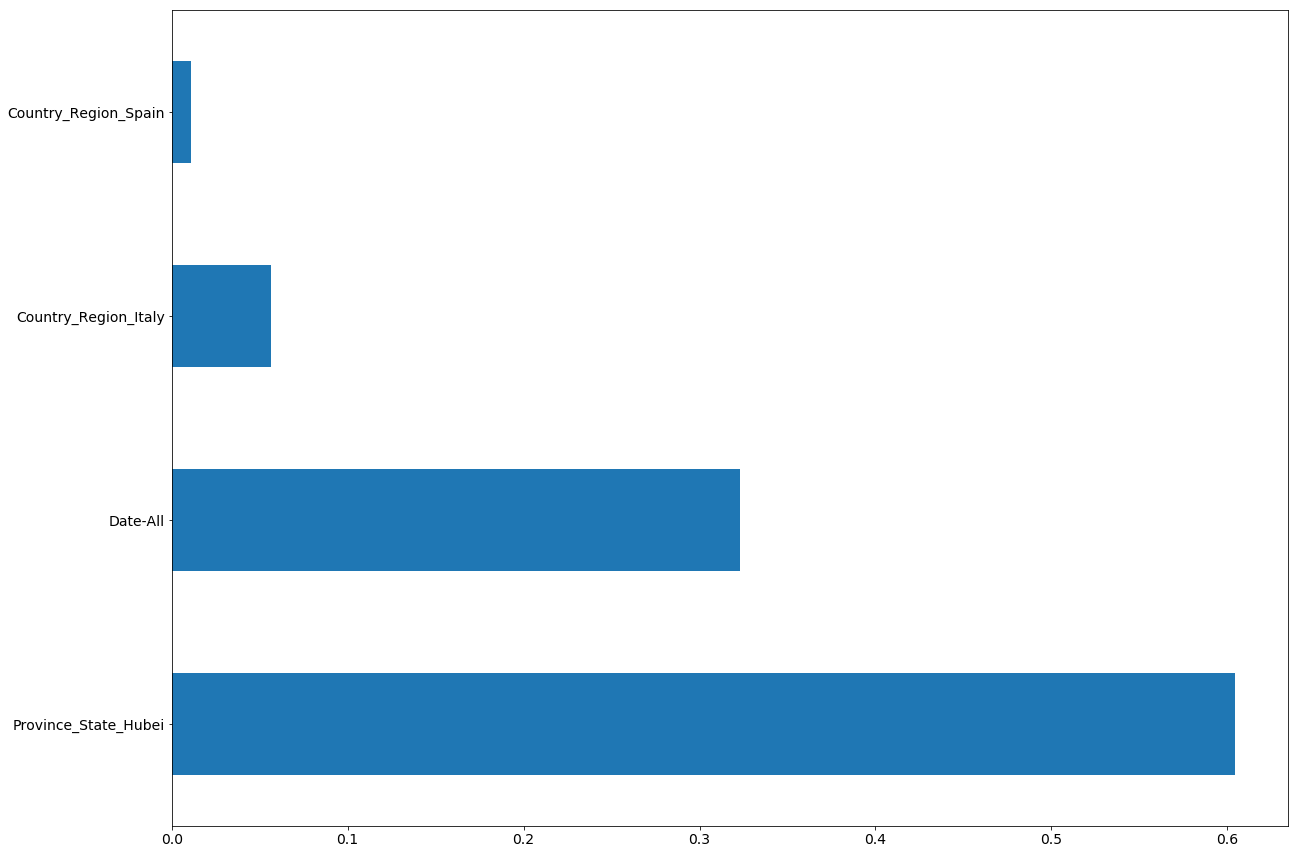

In [30]:
feat_importances = pd.Series(reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(4).plot(kind='barh')

In [31]:
X['yPred'] = reg.predict(X.drop(['Date'],1))
X['yPred'] = X['yPred'].apply(round)
X.loc[X['yPred'] < 0, 'yPred'] = 0
X.loc[:covid19_train.ForecastId.max(),'ConfirmedCases'] = y_train_CC

In [32]:
np.sqrt(mean_squared_error(y_true=X.loc[~X['ConfirmedCases'].isna()]['ConfirmedCases'],
                   y_pred=X.loc[~X['ConfirmedCases'].isna()]['yPred']))

1593.798359770098

In [33]:
r2_score(X.loc[~X['ConfirmedCases'].isna()]['ConfirmedCases'],
                               X.loc[~X['ConfirmedCases'].isna()]['yPred'])

0.8269340997945762

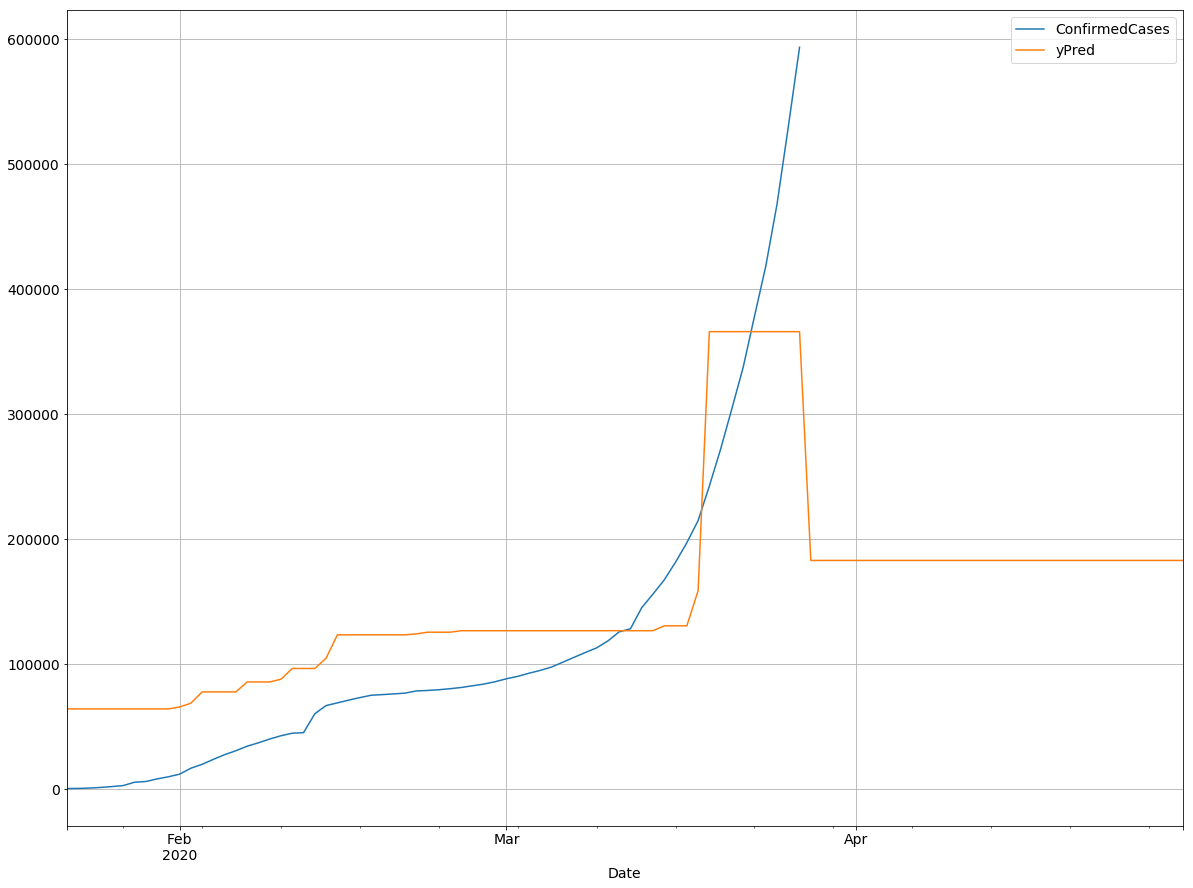

In [34]:
X.set_index('Date').resample('D')[['ConfirmedCases']].sum().replace(0,np.nan).join(X.set_index('Date').resample('D')[['yPred']].sum()).plot(grid=True)

In [35]:
X.drop(['yPred','ConfirmedCases'],1,inplace=True)

In [36]:
kf = KFold(n_splits = 10, shuffle=True)

In [37]:
reg = xgb.XGBRegressor(colsample_bytree=0.85, max_depth=10, n_estimators = 500, learning_rate = 0.01, gamma = 4,seed=42)

In [38]:
rmse = []

In [39]:
for i in range(10):
    offset = next(kf.split(X_train),None)
    x_train = X_train.iloc[offset[0]]
    x_test = X_train.iloc[offset[1]]
    Y_train = y_train_CC[offset[0]]
    Y_test = y_train_CC[offset[1]]

    reg.fit(x_train, Y_train,eval_set=[(x_train, Y_train), 
                  (x_test, Y_test)],
        eval_metric="rmse",verbose=False)
    eval_results = reg.evals_result()
    rmse.append(np.mean(eval_results['validation_0']['rmse']))
    

In [40]:
rmse

[1234.953846664,
 1294.1512728320001,
 1269.0817377940002,
 1288.3707282520002,
 1262.692941666,
 1253.4825138980002,
 1265.470668726,
 1237.1802315639998,
 1283.776386836,
 1276.1551660419998]

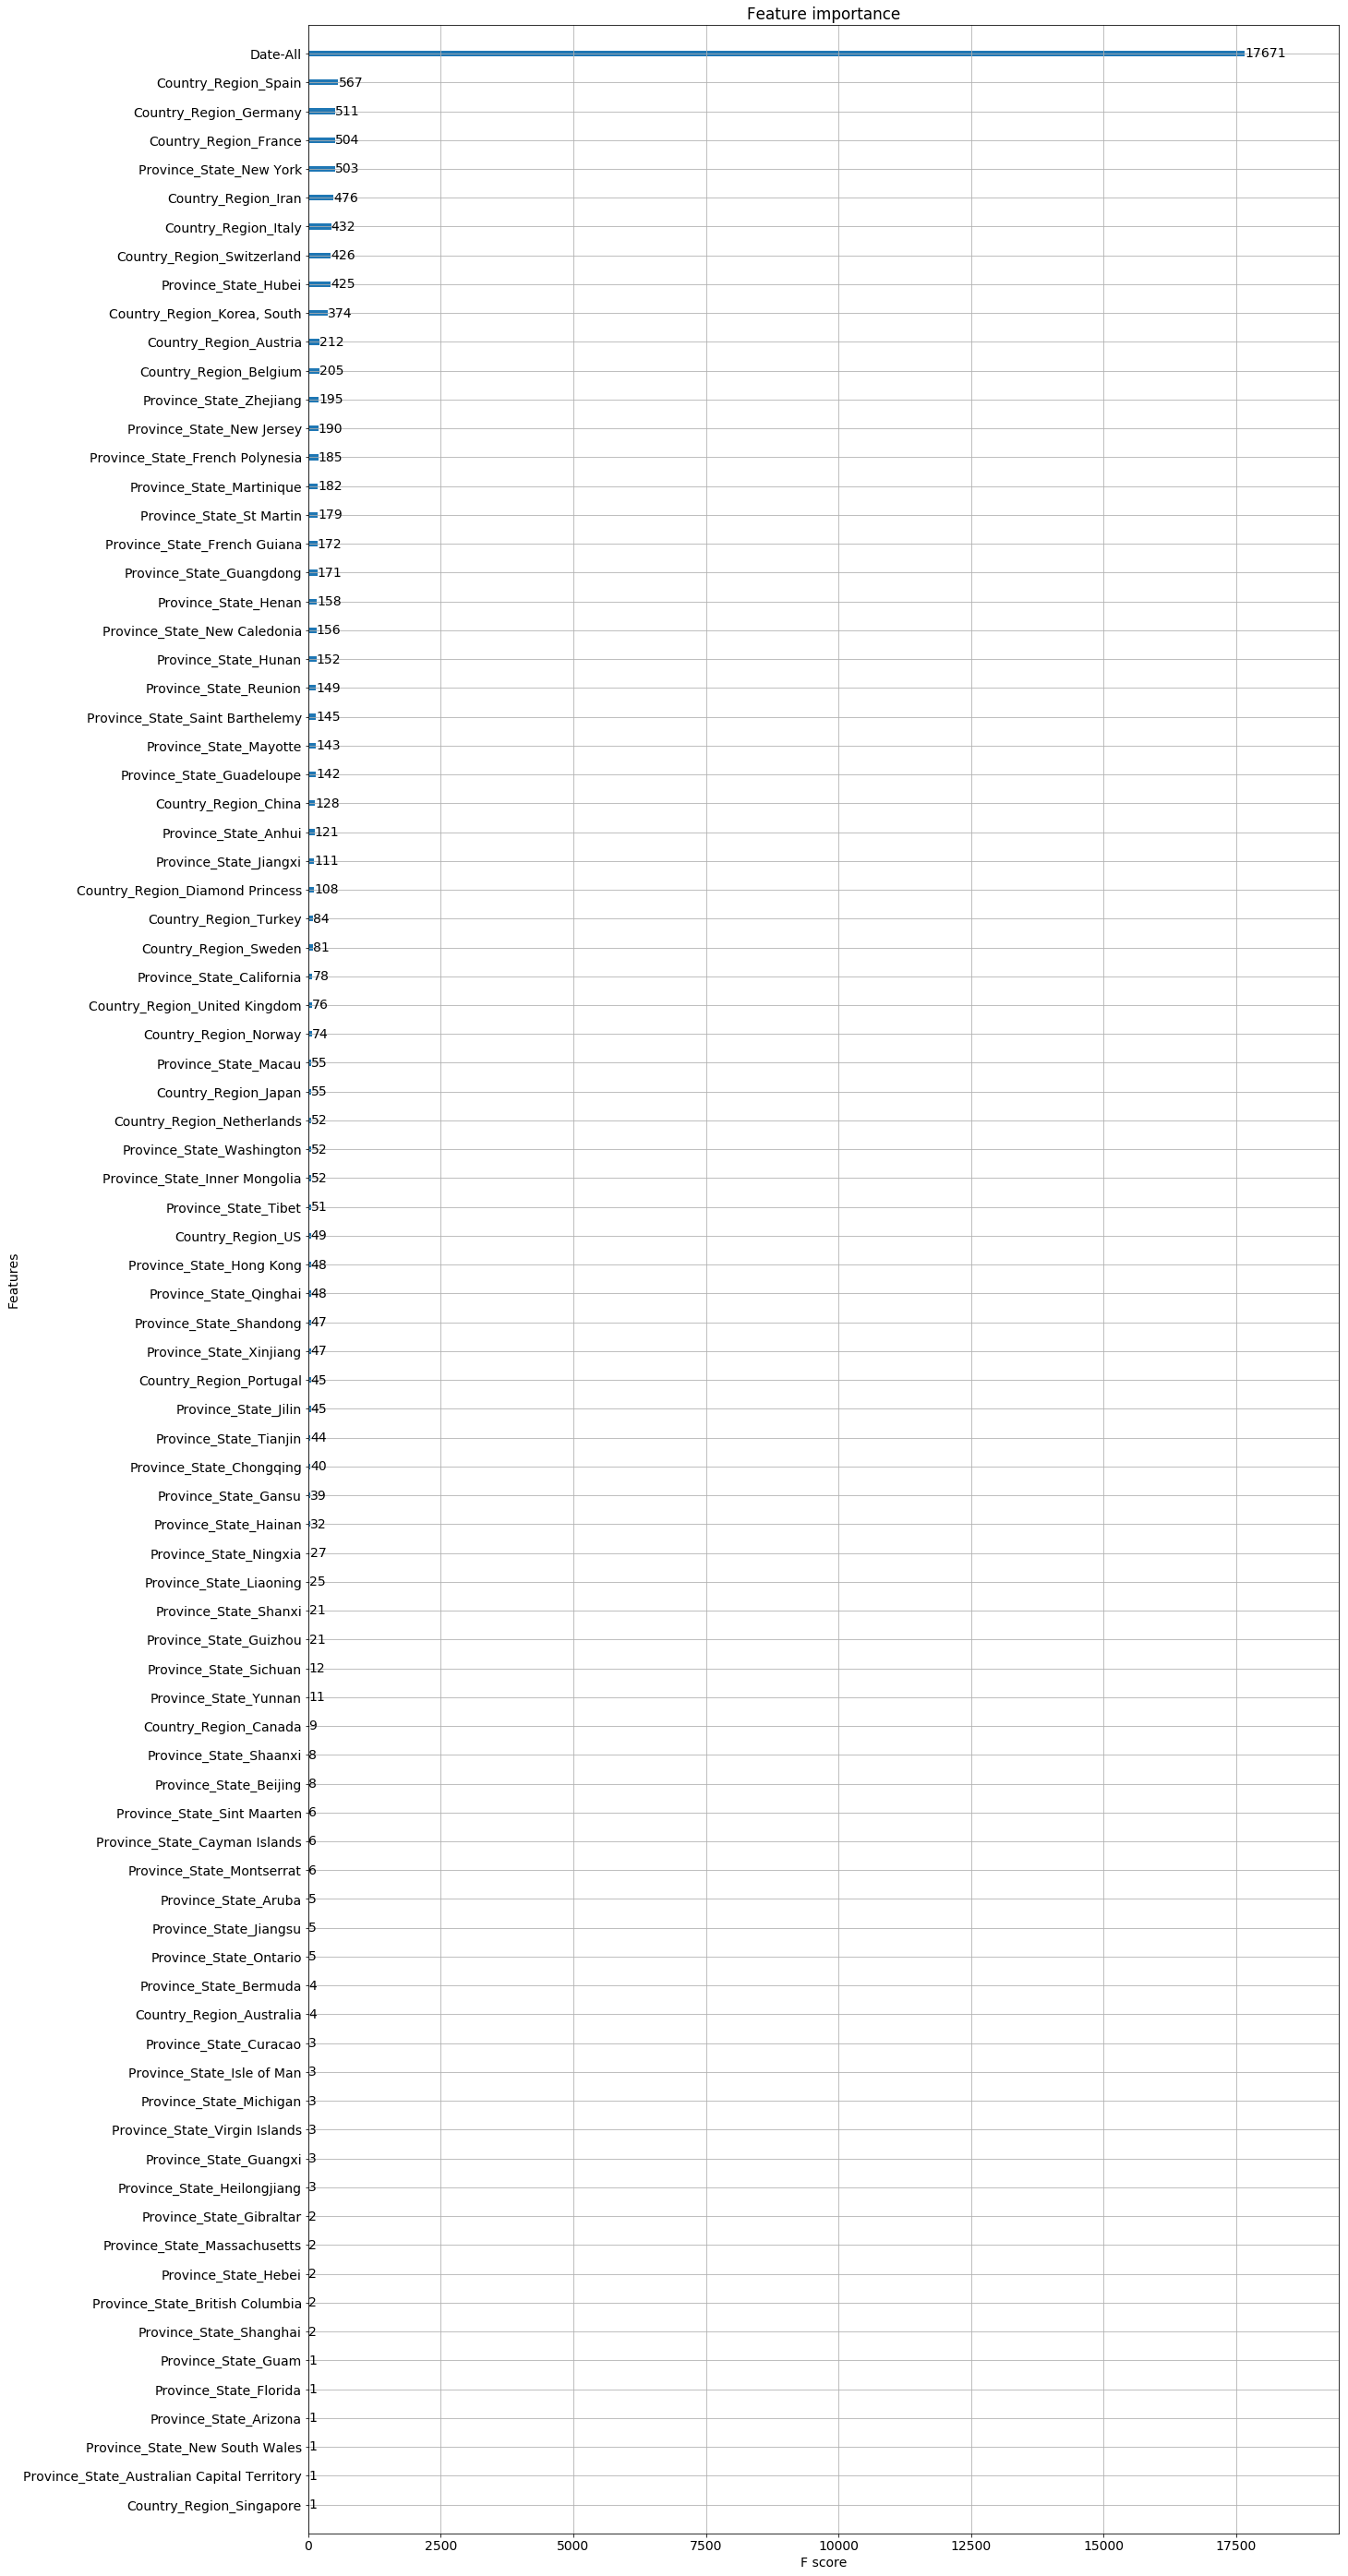

In [41]:
fig, ax = plt.subplots(1,1,figsize=(20,50))
_ = plot_importance(reg,ax=ax)
plt.show()

In [42]:
X['yPred'] = reg.predict(X.drop(['Date'],1))
X['yPred'] = X['yPred'].apply(round)
X.loc[X['yPred'] < 0, 'yPred'] = 0
X.loc[:covid19_train.ForecastId.max(),'ConfirmedCases'] = y_train_CC

In [43]:
np.sqrt(mean_squared_error(y_true=X.loc[~X['ConfirmedCases'].isna()]['ConfirmedCases'],
                   y_pred=X.loc[~X['ConfirmedCases'].isna()]['yPred']))

577.2627297629446

In [44]:
r2_score(X.loc[~X['ConfirmedCases'].isna()]['ConfirmedCases'],
                               X.loc[~X['ConfirmedCases'].isna()]['yPred'])

0.9772965534086806

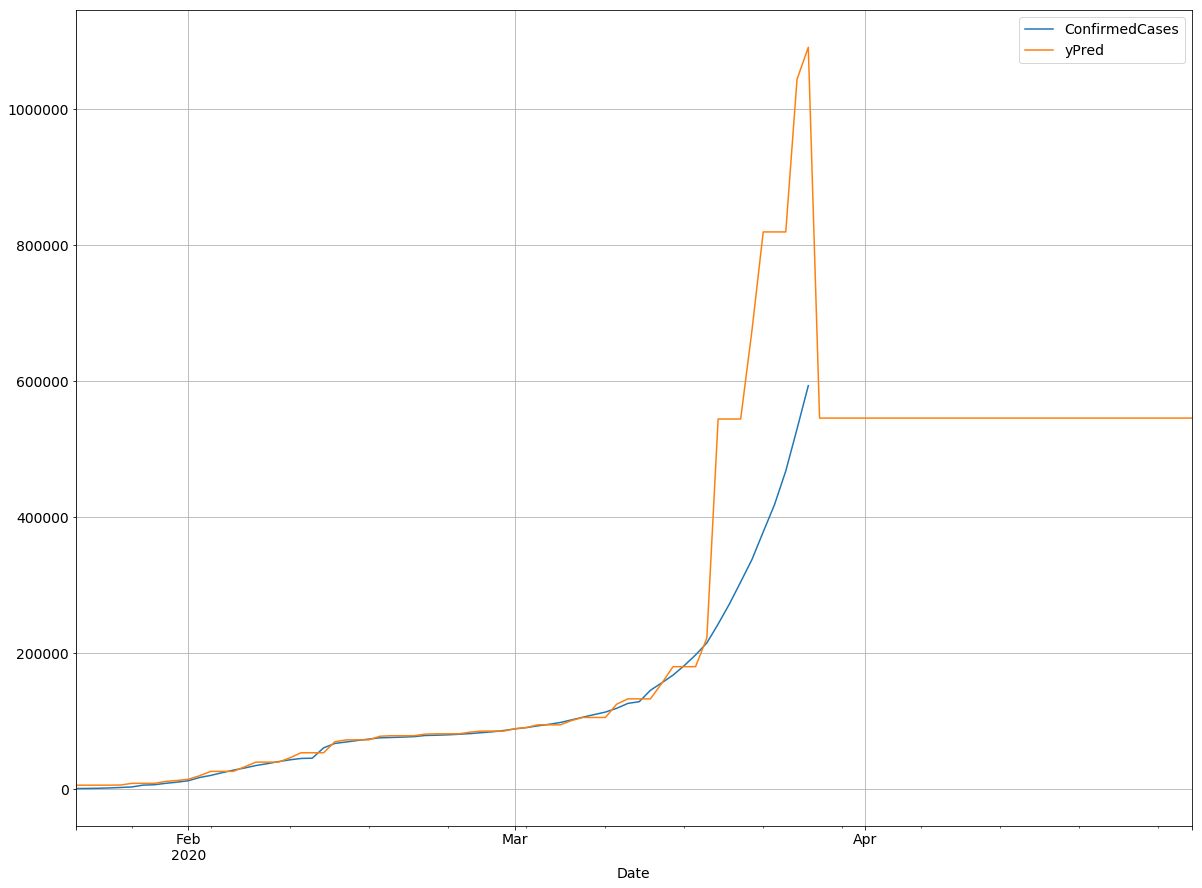

In [45]:
X.set_index('Date').resample('D')[['ConfirmedCases']].sum().replace(0,np.nan).join(X.set_index('Date').resample('D')[['yPred']].sum()).plot(grid=True)

In [46]:
X.drop(['yPred','ConfirmedCases'],1,inplace=True)